In [386]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from sklearn.metrics import mean_squared_error


import numpy as np

In [444]:
f = open("mazes.txt")
mazes = f.read().strip().split("\n\n\n")
print(len(mazes))

6


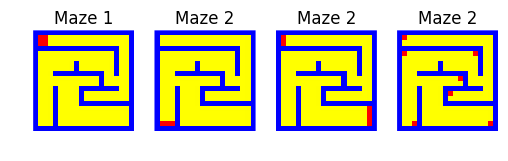

In [44]:
def plotMaze(maze, title=""):
    lines = maze.split("\n")
    height = len(lines)
    width  = len(lines[0])
    density = np.zeros((height, width, 3))
    for i in range(height):
        for j in range(width):
            c = lines[i][j] 
            v = 0
            if c == '#':
                density[i,j,2] = 1
            elif c == 'X':
                density[i,j,0] = 1
            else :
                density[i,j] = [1,1,0]
    plt.axis('off')
    plt.title(title)
    plt.imshow(density, interpolation='none')
plt.subplot(1,4,1)
plotMaze(mazes[0], "Maze 1")
plt.subplot(1,4,2)
plotMaze(mazes[1], "Maze 2")
plt.subplot(1,4,3)
plotMaze(mazes[2], "Maze 2")
plt.subplot(1,4,4)
plotMaze(mazes[3], "Maze 2")

In [349]:
def mazeToMatrix(maze):
    return np.array(map( lambda x : list(x), maze.split("\n")  ))
def coordinateUnroll(x,y, width):
    return x*width + y
def computeTransitionModel(maze):
    grids = maze
    
    size = grids.shape
    height = size[0]
    width  = size[1]
    
    to_tran = lambda x,y: coordinateUnroll(x,y,width)

    actions = ['r','d','l', 't']
    transition = np.zeros((height*width, height*width, 4)) # right, down, left, top
    # compute
    for i in range(height):
        for j in range(width):
            if grids[i,j] == '#':
                continue
            for k in range(len(actions)):
                a = actions[k]
                adj_x = 0
                adj_y = 0

                if a == 'r':
                    adj_y = 1
                elif a == 'd':
                    adj_x = 1
                elif a == 'l':
                    adj_y = -1
                elif a == 't':
                    adj_x = -1
                
                nx = i+adj_x
                ny = j+adj_y

                if grids[nx,ny] != '#':
                    transition[ to_tran(i,j), to_tran(nx,ny), k ] = 1

     # verify
    states = []
    for i in range(height):
        for j in range(width):
            if grids[i,j] == '#':
                continue
            for k in range(len(actions)):
                states.append( np.sum(transition[to_tran(i,j), :, k]) )
    x = range(len(states))
    return transition
# small_maze = "#####\n#X  #\n#  ##\n#   #\n#####"
# print(small_maze)
# # print(mazes[0])
# model1 = computeTransitionModel( mazeToMatrix(small_maze) )
# print(model1.shape)
# re = computeReward(mazeToMatrix(small_maze)).reshape(5*5,1)
# # print(model1[7])
# sp = np.mean( model1, axis=2 )

# v = np.dot( np.linalg.inv(np.identity(25) - 0.9 * sp) , re.reshape(25,1) )

# # print(sp[7,7])
# # for i in range(len(v)):
# #     print("%d : %.4f" % ( i, v[i]))
# # print(v)
# # mean( P(S(:),S(:),:) , 3)
# w = np.zeros((5,5))

# mm = mazeToMatrix(small_maze)
# for i in range(5):
#     for j in range(5):
#         if mm[i,j] == '#':
#             w[i,j] = 1
# # fig = plt.figure(frameon=False)

# print(w)
# ig2 = plt.imshow(v.reshape(5,5), cmap="Reds", interpolation="none")
# ig1 = plt.imshow(w, cmap="Blues", interpolation="none",alpha=0.4)
# plt.show()

In [267]:
def computeReward(maze):
    rewards = np.zeros( maze.shape )
    
    size = rewards.shape
    height = size[0]
    width  = size[1]
    
    for i in range(height):
        for j in range(width):
            if maze[i,j] == 'X':
                rewards[i,j] = 1
    return rewards

In [286]:
def solveMazeAnalytic( maze, gamma=0.9):
    maze  = mazeToMatrix(maze)
    model = computeTransitionModel(maze)
    rewards = computeReward(maze)

    P = np.mean( model, axis=2 )
    first_term = np.linalg.inv(np.identity(maze.shape[0]*maze.shape[1]) - gamma * P)
#     print(gamma*P)
    V = np.dot(first_term, rewards.reshape( maze.shape[0]*maze.shape[1], 1) )
    return V
values1 = solveMazeAnalytic(mazes[0])
print(values1.shape)

(20, 20)
('r', 1, 2, 22)
[ 1.  0.  0.  0.]
('d', 2, 1, 41)
[ 0.  1.  0.  0.]
(400, 1)


/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log


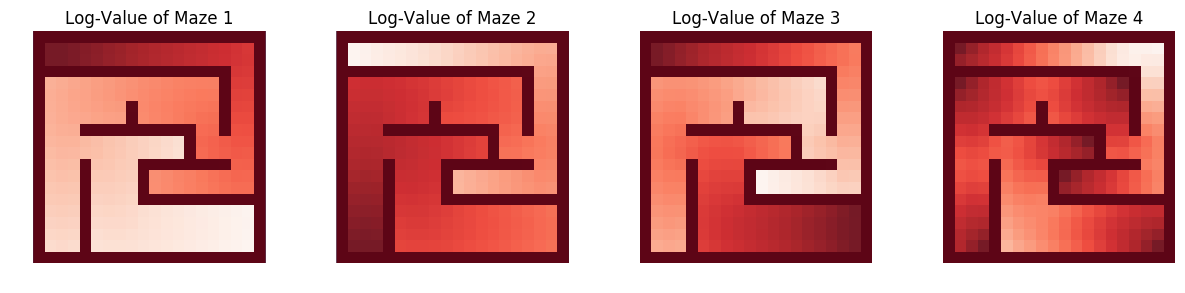

In [373]:
def plotMazeWithValue(maze, values, title=""):

    height = maze.shape[0]
    width  = maze.shape[1]

#     print(values)
    not_wall_idx = np.where( values > 0 )
    
    max_value = np.max(values)
    min_value = np.min(values)
    
    values = (values - min_value ) / ( max_value - min_value )

    
#     print(non_wall_values)
    values = np.log(values)

#     print(values[not_wall_idx])
    values = values.reshape(height,width)

    density = np.zeros((height, width))    
    wall = np.zeros((height, width))    
    for i in range(height):
        for j in range(width):
            c = maze[i,j] 
            v = 0
            if c != '#':
                density[i,j] = values[i,j]
            else :
                wall[i,j] = 1
    plt.axis('off')
    plt.title(title)
    ig1 = plt.imshow(wall, cmap="Blues", interpolation="none")
    ig2 = plt.imshow(density, cmap="Reds", interpolation="none", alpha=0.9)

plt.rcParams["figure.figsize"] = (15,3)
for i in range(4):
    plt.subplot(1,4,i+1)
    m = mazes[i]
    plotMazeWithValue( mazeToMatrix(m), solveMazeAnalytic(m), title="Log-Value of Maze %d"%(i+1) )


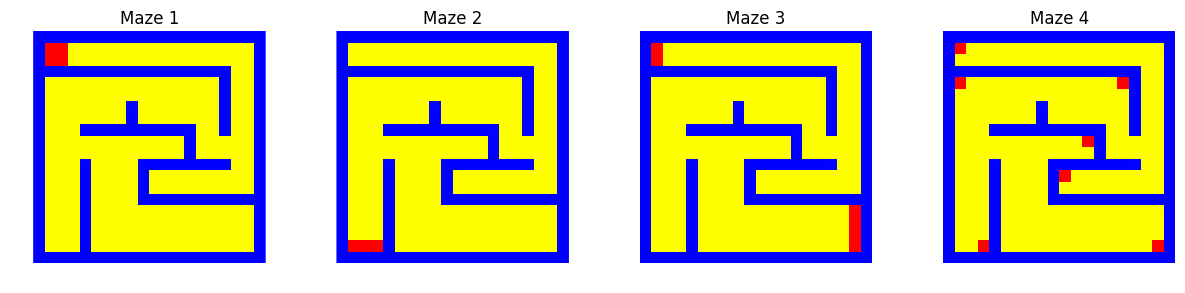

In [215]:
for i in range(4):
    plt.subplot(1,4,i+1)
    plotMaze(mazes[i], "Maze %d"%(i+1))


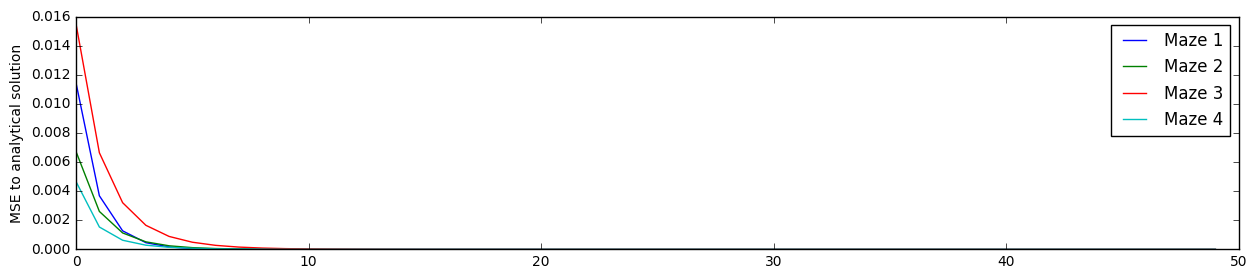

In [400]:
def valueIteration(maze, values=None, gamma=0.9, desc="Maze 1"):

    analytic_values = solveMazeAnalytic(maze)
    maze = mazeToMatrix(maze)
    rewards = computeReward(maze).reshape(maze.shape[0]*maze.shape[1])
    if values is None:
        values  = np.zeros(rewards.shape)
    model   = computeTransitionModel(maze)
    P = np.mean( model, axis=2 )

    mse = []
    for i in range(50):
        values = rewards + gamma * np.dot(P, values)
        mse.append( mean_squared_error(values, analytic_values ))
    plt.plot(mse, label=desc)
    plt.ylabel("MSE to analytical solution")
    plt.legend()
    
for i in range(4):
    valueIteration(mazes[i], desc="Maze %d" % (i+1) )

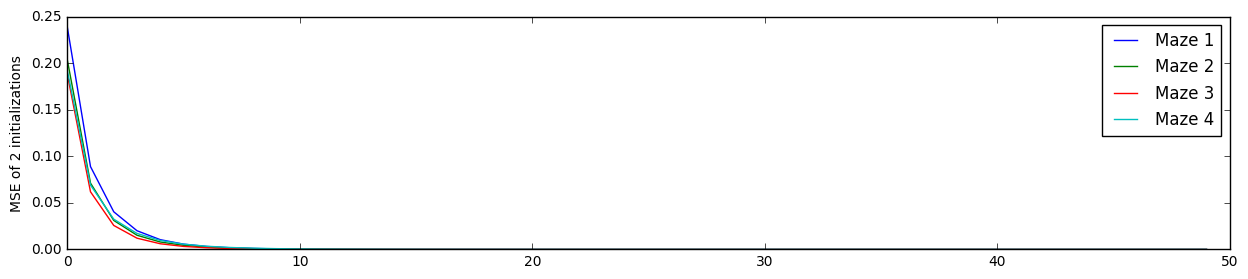

In [405]:
def valueIterationWith2Random(maze, gamma=0.9, desc="Maze 1"):

    analytic_values = solveMazeAnalytic(maze)
    maze = mazeToMatrix(maze)
    rewards = computeReward(maze).reshape(maze.shape[0]*maze.shape[1])
    values1 = np.random.normal(0, 1, rewards.shape)
    values2 = np.random.normal(0, 1, rewards.shape)

    model   = computeTransitionModel(maze)
    P = np.mean( model, axis=2 )

    mse = []
    for i in range(50):
        values1 = rewards + gamma * np.dot(P, values1)
        values2 = rewards + gamma * np.dot(P, values2)
        mse.append( mean_squared_error(values1, values2 ))
    plt.plot(mse, label=desc)
    plt.ylabel("MSE of 2 initializations")
    plt.legend()
    
for i in range(4):
    values = np.random.normal(0, 1, 400)
    valueIterationWith2Random(mazes[i], desc="Maze %d" % (i+1) )

# H13.2 : Find a good policy